In [2]:
import pandas as pd
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.contrib import learn
df_With_Words=pd.read_csv('./parsed data/table.csv')
df= df_With_Words.copy()
if 'is_spam' in df:
    y = df['is_spam'].values # get the labels we want
    del df['is_spam'] # get rid of the class label
    X_words=df['payload'].values
    
    X=df.values
sc =StandardScaler()

#normalize data
#X=sc.fit_transform(X)
#train-test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
Xwords_train, Xwords_test, ywords_train, ywords_test = train_test_split(X_words, y, test_size=0.8)
print(len(X_test))
# Split X_train again to create validation data
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.8)
Xwords_train, Xwords_val, ywords_train, ywords_val = train_test_split(Xwords_train,ywords_train,test_size=0.8)

47873


# Modeling

## MODEL 1 

RNN's are great for natural  language processing, so we decided to use one on our email dataset and train it because we think that spam has specifific features within the body of a message that could be exploited by an rnn.. We decided to use the text classification model that was shown in class because it  was classifying text. We ran into some issues trying to program the rnn model explicitly. It was taking about half an hour to an hour to run and not producing results that were relevant, so we decided to use the RNN classifier from the learn library

In [3]:
# example from https://github.com/tensorflow/tensorflow/blob/r0.11/tensorflow/examples/skflow/text_classification.py.
MAX_DOCUMENT_LENGTH = 100
EMBEDDING_SIZE = 50
# Process vocabulary
vocab_processor = learn.preprocessing.VocabularyProcessor(MAX_DOCUMENT_LENGTH)
Xwords_train = np.array(list(vocab_processor.fit_transform(Xwords_train)))
Xwords_test = np.array(list(vocab_processor.transform(Xwords_test)))
Xwords_val = np.array(list(vocab_processor.transform(Xwords_val)))
n_words = len(vocab_processor.vocabulary_)
print('Total words: %d' % n_words)

Total words: 117364


In [20]:
#super slow and not good results, so decided to use the simpler code, which works and is fast
'''
def rnn_model(x, y):
    """Recurrent neural network model to predict from sequence of words
    to a class."""
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size, sequence_length,
    # EMBEDDING_SIZE].
    word_vectors = learn.ops.categorical_variable(x, n_classes=n_words,
      embedding_size=EMBEDDING_SIZE, name='words')
    # Split into list of embedding per word, while removing doc length dim.
    # word_list results to be a list of tensors [batch_size, EMBEDDING_SIZE].
    word_list = tf.unpack(word_vectors, axis=1)

    # Create a Gated Recurrent Unit cell with hidden size of EMBEDDING_SIZE.
    cell = tf.nn.rnn_cell.GRUCell(EMBEDDING_SIZE)

    # Create an unrolled Recurrent Neural Networks to length of
    #MAX_DOCUMENT_LENGTH and passes word_list as inputs for each unit.
    _, encoding = tf.nn.rnn(cell, word_list, dtype=tf.float32)

    # Given encoding of RNN, take encoding of last step (e.g hidden size of the
    # neural network of last step) and pass it as features for logistic
    # regression over output classes.
    target = tf.one_hot(y, 2, 1, 0)
    prediction, loss = learn.models.logistic_regression(encoding, target)
    # Create a training op.
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(),
    optimizer='Adam', learning_rate=0.01)
    return {'class': tf.argmax(prediction, 1), 'prob': prediction}, loss, train_op
'''

In [ ]:
'''
classifier = learn.Estimator(model_fn=rnn_model)

# Train and predict
y_train=y_train.astype("uint8")
y_test=y_test.astype("uint8")
classifier.fit(x_train, y_train, steps=100)
y_predicted = [
    p['class'] for p in classifier.predict(x_test, as_iterable=True)]
score = metrics.accuracy_score(y_test, y_predicted)
print('Accuracy: {0:f}'.format(score))'''


In [6]:
%%time
from sklearn import metrics
import tensorflow as tf
import numpy as np
import pandas
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib import learn
def input_op_fn(x):
    """Customized function to transform batched x into embeddings."""
    # Convert indexes of words into embeddings.
    # This creates embeddings matrix of [n_words, EMBEDDING_SIZE] and then
    # maps word indexes of the sequence into [batch_size, sequence_length,
    # EMBEDDING_SIZE].
    word_vectors = learn.ops.categorical_variable(x, n_classes=n_words,
      embedding_size=EMBEDDING_SIZE, name='words')
    # Split into list of embedding per word, while removing doc length dim.
    # word_list results to be a list of tensors [batch_size, EMBEDDING_SIZE].
    word_list = tf.unpack(word_vectors, axis=1)
    return word_list

classifier = learn.TensorFlowRNNClassifier(
        rnn_size=EMBEDDING_SIZE, n_classes=2, cell_type='lstm',
        input_op_fn=input_op_fn, num_layers=1, bidirectional=False,
        sequence_length=None, optimizer='Adam',
        learning_rate=0.01, continue_training=True)

# Train and predict
classifier.fit(Xwords_train, ywords_train, steps=200)
y_predicted = classifier.predict(Xwords_val)
score = metrics.precision_score(ywords_val, y_predicted)
print('Accuracy: {0:f}'.format(score))

Accuracy: 0.953633
CPU times: user 1min 55s, sys: 11.8 s, total: 2min 7s
Wall time: 1min 33s


In [7]:
#HOUR to run
#crashed because I used 1 in learning_rate, but scores appended for rest of them were still there, so was able to create
#graph
#didn't have time to run again
learning_rates=[.001, .01, .1]
num_layers=[1,2,3,4,5]

scores=[]
for i in learning_rates:
    for j in num_layers:
        classifier = learn.TensorFlowRNNClassifier(
        rnn_size=EMBEDDING_SIZE, n_classes=2, cell_type='lstm',
        input_op_fn=input_op_fn, num_layers=j, bidirectional=False,
        sequence_length=None, optimizer='Adam',
        learning_rate=i, continue_training=True)
        # Train and predict
        classifier.fit(Xwords_train, ywords_train, steps=200)
        y_predicted = classifier.predict(Xwords_val)
        score = metrics.precision_score(ywords_val, y_predicted)
        scores.append(score)
print(scores)

ValueError: Learning rate should be 0d Tensor or float. Got 1 of type <class 'int'>

15


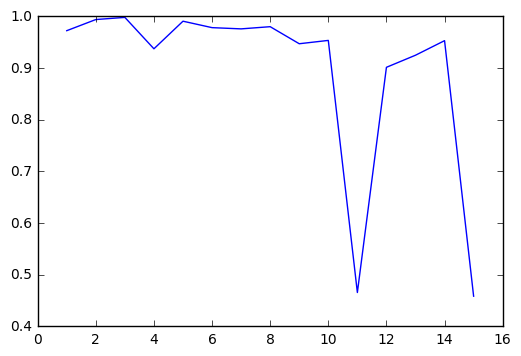

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
print(len(scores))
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], scores)

Based on the results above, combination 3(learning rate of .001 and 3 layers) had the best results on the validation set. Unfortunately we ran out of time and couldn't calculate the biases, so :(. 

In [14]:
classifier = learn.TensorFlowRNNClassifier(
        rnn_size=EMBEDDING_SIZE, n_classes=2, cell_type='lstm',
        input_op_fn=input_op_fn, num_layers=3, bidirectional=False,
        sequence_length=None, optimizer='Adam',
        learning_rate=0.001, continue_training=True)

# Train and predict
classifier.fit(Xwords_train, ywords_train, steps=200)
y_predicted = classifier.predict(Xwords_test)
score = metrics.precision_score(ywords_test, y_predicted)
print('Accuracy: {0:f}'.format(score))

Accuracy: 0.996981


## MODEL 2

In [ ]:
COLUMNS = ["payload_smog_index", "organization", "multipart_count", "kl_divergence_eng_lang", "payload_dale_chall_readability_score",
           "frm_fuzz_set_ratio", "cc"]
LABEL="is_spam"
CATEGORICAL_COLUMNS = [ "cc","organization"]
CONTINUOUS_COLUMNS = ["payload_smog_index","multipart_count","kl_divergence_eng_lang","payload_dale_chall_readability_score", "frm_fuzz_set_ratio"]